In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime
import gmplot
import matplotlib.colors as cl

In [2]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    #convert from decimal degrees to radians
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    #haversine formula for a great circle distance
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082 #earth's radius in miles at London (0 elevation)
    
    return c*r

def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
        from: https://github.com/dylburger/reading-api-key-from-file/blob/master/Keeping%20API%20Keys%20Secret.ipynb
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [3]:
#google maps API key
api_key = get_file_contents('./Keys/google_maps.txt')

#road class conversion of CYCLANDS 1st_Road_Class variable
road_classes = np.array(['','M','A(M)','A','B','C','U','na'])

##upper left, lower right corners of Greater London (lat,long)

#Dan's
corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

#Greg's
# corners = [(51.543,-0.179),(51.475,0.023)]

In [4]:
#collision data from CYCLANDS
collisions = pd.read_csv('./uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values
collisions.Road_name = collisions.Road_name.str.replace('U0','U')
collisions.Road_name = collisions.Road_name.str.replace('C0','C')
collisions['Road_name2'] = road_classes[collisions['2nd_Road_Class'].values].astype(object)+collisions['2nd_Road_Number'].apply(str).values
collisions.Road_name2 = collisions.Road_name2.str.replace('U0','U')
collisions.Road_name2 = collisions.Road_name2.str.replace('C0','C')

#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('./uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [327]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],1)
    
    #count correct geomatches
    matches += np.sum(aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values)
    
    A_match = A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print('% matched:',len(A_match)/len(collisions_year))
    print()

print('total')
print('Correct geo match:',matches)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)

2005
mean distance to CP: 0.08802650674194297
median distance to CP: 0.06518540058274697
max distance to CP: 0.420734100424044
min distance to CP: 0.0025005235440245023
Correct geo match: 449
Total London collisions: 978
% matched: 0.4591002044989775

2006
mean distance to CP: 0.0929351893041538
median distance to CP: 0.06586925060628641
max distance to CP: 0.6171844096822772
min distance to CP: 0.0025709668155781402
Correct geo match: 510
Total London collisions: 1088
% matched: 0.46875

2007
mean distance to CP: 0.09729826700707805
median distance to CP: 0.0672322823503299
max distance to CP: 0.574799588421124
min distance to CP: 0.002571929174308482
Correct geo match: 540
Total London collisions: 1099
% matched: 0.4913557779799818

2008
mean distance to CP: 0.08702808284237493
median distance to CP: 0.064794455625575
max distance to CP: 0.5276425133499693
min distance to CP: 0.002573319643253185
Correct geo match: 604
Total London collisions: 1224
% matched: 0.4934640522875817

2009

Text(0.5, 1.0, '2018')

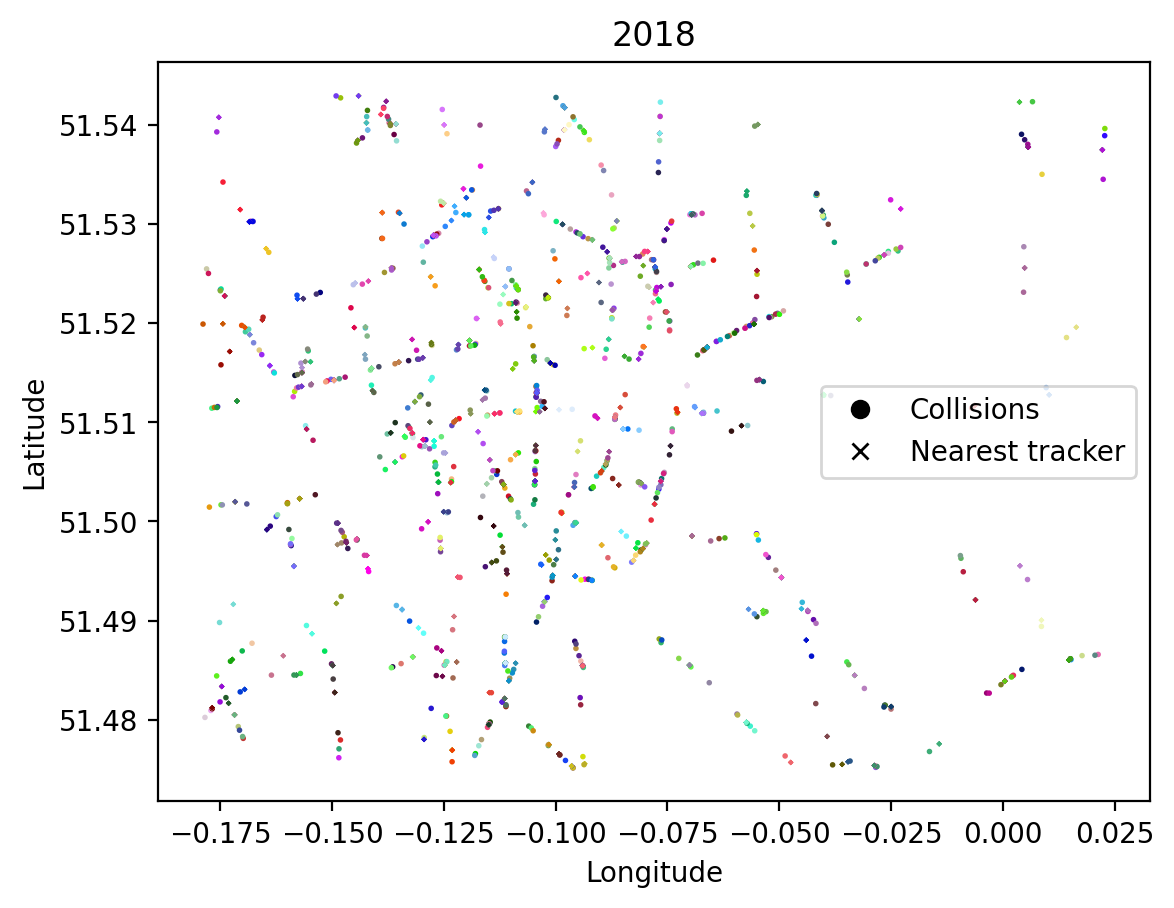

In [5]:
plotN = 700

colors = np.random.rand(plotN,3)

match_mask = aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match_mask].head(plotN).Longitude,collisions_year.iloc[match_mask].head(plotN).Latitude,c=colors,s=1)
# for i,(txt,long,lat) in enumerate(zip(collisions_year.iloc[match_mask].head(plotN).Road_name.values,collisions_year.iloc[match_mask].head(plotN).Longitude.values,collisions_year.iloc[match_mask].head(plotN).Latitude.values)):
#     ax.annotate(txt, (long,lat),color='black')


ax.scatter(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)
# for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values)):
#     ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')

## Examine nearest neighbors

In [75]:
year = 2018

aadf2018 = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
collisions2018 = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()

In [76]:
from sklearn.neighbors import NearestNeighbors

In [77]:
neigh = NearestNeighbors(n_neighbors=1,radius=0.1)

In [78]:
neigh.fit(aadf2018[['Longitude','Latitude']])

NearestNeighbors(n_neighbors=1, radius=0.1)

In [79]:
A,B = neigh.kneighbors(collisions2018[['Longitude','Latitude']],10)

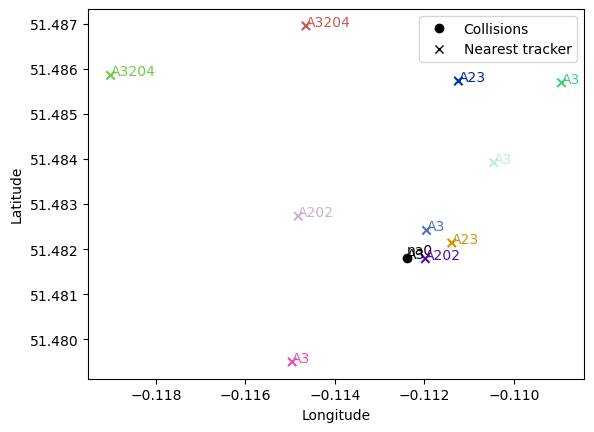

In [84]:
plotN = 20

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude,c='black')
ax.annotate(road_classes[collisions2018.iloc[plotN]['1st_Road_Class']]+str(collisions2018.iloc[plotN]['1st_Road_Number']), (collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude),color='black')
# ax.annotate(road_classes[collisions2018.iloc[plotN]['2nd_Road_Class']]+str(collisions2018.iloc[plotN]['2nd_Road_Number']), (collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude+0.0001),color='black')

ax.scatter(aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [49]:
aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values

array(['A200', 'A101', 'A2206', 'A2208', 'A2208', 'A2208', 'A2208', 'C',
       'A200', 'A200', 'U', 'A2208', 'A1203', 'A101', 'A200', 'U', 'A200',
       'A200', 'B207', 'A13'], dtype=object)

In [55]:
aadf2018.iloc[B[plotN].flatten().tolist()].Start_junction_road_name.values

array(['A101', 'A200', 'A100/A2205', 'A2206', 'Rotherhithe New Rd',
       'Hawkstone Rd', 'A2', nan, 'A2208', 'A2208', nan, 'A200', 'A1202',
       'LA Boundary', 'A2208', nan, 'A2208', 'B202', nan,
       'A11/A1202 mid-junction'], dtype=object)

In [174]:
aadf_year.iloc[B.flatten().tolist()].Road_name.values

array(['A4206', 'A4000', 'U', ..., 'A780', 'A701', 'A75'], dtype=object)

In [173]:
collisions_year.Road_name.values

16852

In [183]:
A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]

array([[0.00530392],
       [0.00040256],
       [0.00213593],
       ...,
       [0.0206665 ],
       [0.00153796],
       [0.00337566]])

In [195]:
len(collisions)

250963

## Check k>1 nearest neighbor for match

In [15]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],10)
    
#     #count correct geomatches

    match_idx = np.zeros((len(B),10))
    
    for i in range(10):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
        
    matches += match.sum()
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print('% matched:',match.sum()/len(collisions_year))
    print()

print('total')
print('Correct geo match:',matches)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)

2005
mean distance to CP: 0.33401465273688935
median distance to CP: 0.21477632512539982
max distance to CP: 3.7334188151988337
min distance to CP: 0.0025005235440245023
Correct geo match: 2481
Total London collisions: 3323
% matched: 0.7466145049653927

2006
mean distance to CP: 0.3260673204874244
median distance to CP: 0.2094736783133988
max distance to CP: 2.877680160266873
min distance to CP: 0.0025709668155781402
Correct geo match: 2548
Total London collisions: 3387
% matched: 0.7522881606141127

2007
mean distance to CP: 0.31199984137854375
median distance to CP: 0.2048796371057111
max distance to CP: 3.2493461324926893
min distance to CP: 0.0008388965305746833
Correct geo match: 2553
Total London collisions: 3393
% matched: 0.7524314765694076

2008
mean distance to CP: 0.2890008028435602
median distance to CP: 0.19495928345166158
max distance to CP: 3.722916888242345
min distance to CP: 0.0023653730117970434
Correct geo match: 2967
Total London collisions: 3643
% matched: 0.8144

Text(0.5, 1.0, '2018')

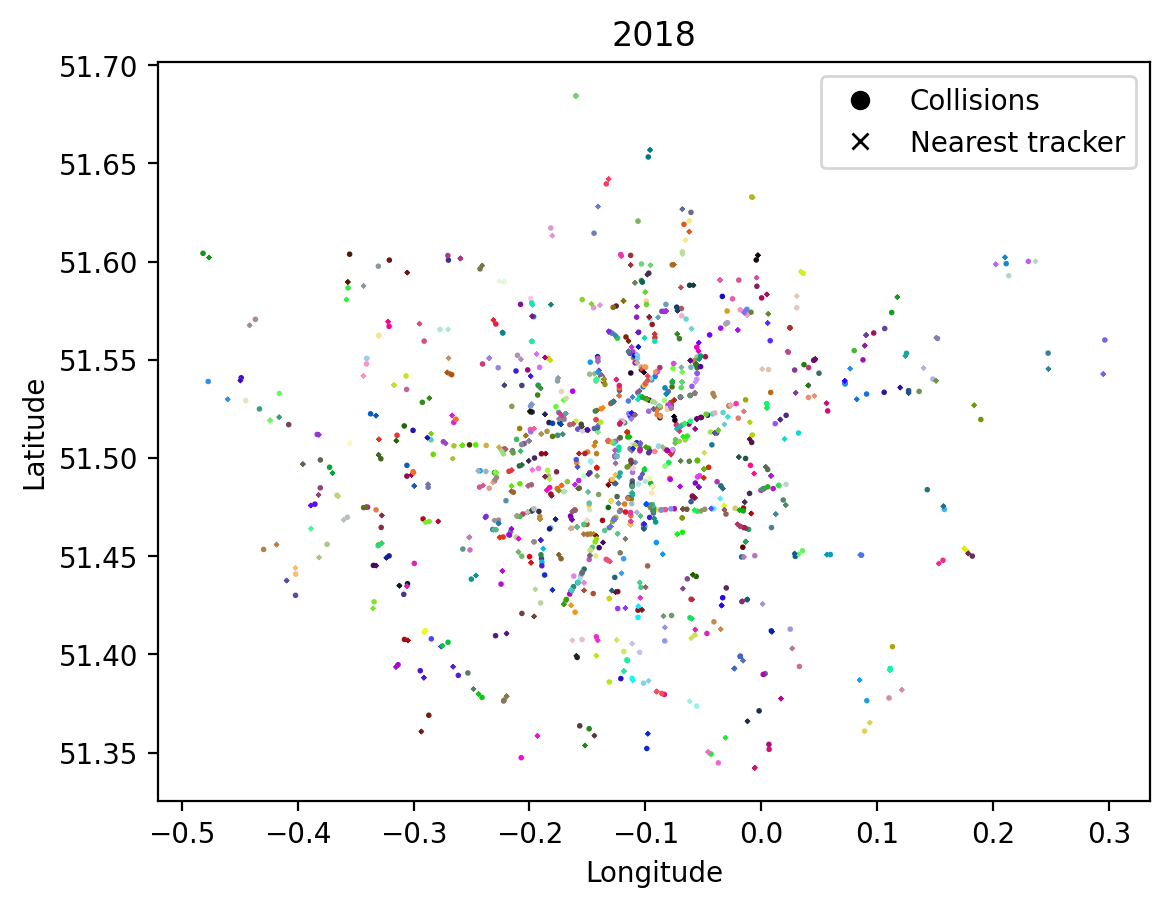

In [16]:
plotN = 700

colors = np.random.rand(plotN,3)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match].head(plotN).Longitude,collisions_year.iloc[match].head(plotN).Latitude,c=colors,s=1)
# for i,(txt,long,lat) in enumerate(zip(collisions_year.iloc[match_mask].head(plotN).Road_name.values,collisions_year.iloc[match_mask].head(plotN).Longitude.values,collisions_year.iloc[match_mask].head(plotN).Latitude.values)):
#     ax.annotate(txt, (long,lat),color='black')


ax.scatter(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)
# for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values)):
#     ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')

0


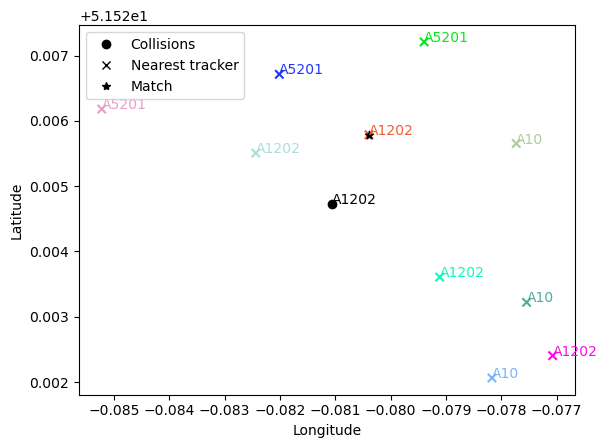

In [12]:
plotN = 100

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match].iloc[plotN].Longitude,collisions_year.iloc[match].iloc[plotN].Latitude,c='black')
ax.annotate(road_classes[collisions_year.iloc[match].iloc[plotN]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[plotN]['1st_Road_Number']), (collisions_year.iloc[match].iloc[plotN].Longitude,collisions_year.iloc[match].iloc[plotN].Latitude),color='black')

ax.scatter(aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match][plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])
    
print(check[match][plotN])

ax.scatter(aadf_year.iloc[B_match[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[plotN].flatten().tolist()].Latitude.values,c='black',marker='*')

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [8]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [9]:
api_key = get_file_contents('./Keys/google_maps.txt')

In [17]:
plotN = 700

colors = np.random.rand(plotN,3)

gmap = gmplot.GoogleMapPlotter(collisions_year.iloc[match].iloc[0].Latitude,collisions_year.iloc[match].iloc[0].Longitude,13,apikey=api_key)

gmap.scatter(collisions_year.iloc[match].head(plotN).Latitude,collisions_year.iloc[match].head(plotN).Longitude, color='red')
for i,(long,lat) in enumerate(zip(collisions_year.iloc[match].head(plotN).Longitude.values,collisions_year.iloc[match].head(plotN).Latitude.values)):
    road_name = road_classes[collisions_year.iloc[match].iloc[i]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[i]['1st_Road_Number'])
    gmap.text(lat,long,road_name,color='red')

gmap.scatter(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,c='blue')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values)):
    gmap.text(lat,long,txt,color='blue')

gmap.draw(r"C:\Users\tuthill.15\Documents\code-2022\Final Project\Plots\map2.html")

In [15]:
plotN = 0

gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude,13,apikey=api_key)

gmap1.marker(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude, color='cornflowerblue')
road_name = road_classes[collisions_year.iloc[match].iloc[plotN]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[plotN]['1st_Road_Number'])
gmap1.text(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude, text=road_name,color='cornflowerblue')

gmap1.scatter(aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,c='red')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match][plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values)):
    gmap1.text(lat,long,txt,color='red')


gmap1.draw(r"C:\Users\tuthill.15\Documents\code-2022\Final Project\Plots\map1.html")

## Examine 2nd road from collision

In [86]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0
london_col_nonan = 0
too_fars = 0

k_neighbor = 50

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    london_col_nonan += len(collisions_year)
    
    #find nearest aadf cp neighbor to collisions
    # neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1)
    # neigh.fit(aadf_year[['Longitude','Latitude']])
    # A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],k_neighbor)
    
    neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
    neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
    A,B = neigh.kneighbors(np.radians(collisions_year[['Latitude','Longitude']]),k_neighbor)
    
#     #count correct geomatches

    match_idx = np.zeros((len(B),k_neighbor))
    
    for i in range(k_neighbor):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    try:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    except:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['C']].values.sum()/(check == -1).sum()
        
    print(year)
#     print('mean distance to CP:',A_match.mean()*61.8)
#     print('median distance to CP:',np.median(A_match)*61.8)
#     print('max distance to CP:',A_match.max()*61.8)
#     print('min distance to CP:',A_match.min()*61.8)
#     print('Correct geo match:',len(A_match))
#     print('Total London collisions:',len(collisions_year))
#     print('Unlabeled unmatched collisions:',Unlabeled)
#     print()
    
#     #for check idx = -1, look at 2nd labeled road in collision
    for i in range(k_neighbor):
        
        match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
        
        # if i == 0:
        #     print(np.where(match2 & (check == -1)))
        match_idx[match2 & (check == -1),i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
    
    matches += match.sum()
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    try:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    except:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['C']].values.sum()/(check == -1).sum()
    
    dist = distance(collisions_year.Longitude.values,collisions_year.Latitude.values,aadf_year.iloc[B[np.arange(B.shape[0]),check]].Longitude.values,aadf_year.iloc[B[np.arange(B.shape[0]),check]].Latitude.values)*1.15078
    
    too_far = (dist[match] <= aadf_year.iloc[B_match].Link_length_miles.values)
    nan_outside = np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()/(np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()+(dist[match] > aadf_year.iloc[B_match].Link_length_miles.values).sum())
    too_fars += too_far.sum()
    
    london_col_nonan -= np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()
    
    too_far_all = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)
    
    # print('2nd road added')
    print('mean distance to CP:',dist[match].mean())
    print('median distance to CP:',np.median(dist[match]))
    print('max distance to CP:',dist[match].max())
    print('min distance to CP:',dist[match].min())
    print()
    print('mean distance to CP within tracker boundary:',dist[match][too_far].mean())
    print('median distance to CP within tracker boundary:',np.median(dist[match][too_far]))
    print('max distance to CP within tracker boundary:',dist[match][too_far].max())
    print('min distance to CP within tracker boundary:',dist[match][too_far].min())
    print()
    print('Correct geo match:',match.sum())
    print('Correct geo match within tracker boundary:',too_far.sum())
    print('k>9 matches inside boundary',np.where((check > 9) & too_far_all,1,0).sum())
    print('largest k within boundary',np.max(check[too_far_all]))
    print('% outside boundary with nan value',nan_outside)
    print()
    print('Unlabeled unmatched collisions:',Unlabeled)
    print()
    print('Total London collisions:',len(collisions_year))
    print()
    print('% matched:',match.sum()/len(collisions_year))
    print('% matched in boundary:',too_far.sum()/len(collisions_year))
    print('% matched in boundary (not counting nan):',too_far.sum()/(len(collisions_year)-np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()))
    
    print()
    print()
    print()

print('total')
print('Correct geo match:',matches)
print('Correct geo match within tracker boundary:',too_fars)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)
print('% matched in boundary:',too_fars/london_col)
print('% matched in boundary (not counting nan):',too_fars/london_col_nonan)

2005
mean distance to CP: 0.4763118989849019
median distance to CP: 0.2877320315088447
max distance to CP: 6.1658930112142425
min distance to CP: 0.0028655269873784864

mean distance to CP within tracker boundary: 0.23002435190857454
median distance to CP within tracker boundary: 0.14859360071247202
max distance to CP within tracker boundary: 3.0065481838632278
min distance to CP within tracker boundary: 0.0028655269873784864

Correct geo match: 3073
Correct geo match within tracker boundary: 1770
k>9 matches inside boundary 23
largest k within boundary 46
% outside boundary with nan value 0.8687643898695319

Unlabeled unmatched collisions: 0.176

Total London collisions: 3323

% matched: 0.924766777008727
% matched in boundary: 0.5326512187782124
% matched in boundary (not counting nan): 0.8078502966681881



2006
mean distance to CP: 0.4570608136539499
median distance to CP: 0.27998547747076047
max distance to CP: 5.684734908892633
min distance to CP: 0.0029452977992254297

mean dist

0


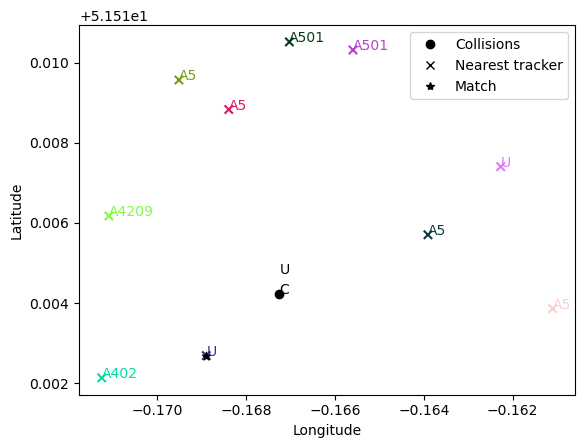

In [10]:
plotN = 38

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude,c='black')
ax.annotate(collisions_year.iloc[plotN].Road_name, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude),color='black')
ax.annotate(collisions_year.iloc[plotN].Road_name2, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude+0.0005),color='black')

ax.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])
    
print(check[plotN])

ax.scatter(aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Latitude.values,c='black',marker='*')

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [42]:
secondary_matches = np.array([   4,   38,   75,  124,  149,  156,  205,  244,  251,  289,  293,
        302,  329,  340,  458,  459,  469,  472,  504,  518,  558,  579,
        587,  619,  626,  641,  675,  724,  771,  782,  797,  854,  861,
        866,  872,  880,  882,  896,  920,  921,  937,  976,  987, 1006,
       1035, 1039, 1057, 1062, 1094, 1115, 1133, 1141, 1143, 1228, 1240,
       1266, 1293, 1327, 1346, 1432, 1446, 1460, 1485, 1500, 1543, 1567,
       1569, 1583, 1632, 1648, 1675, 1691])

In [103]:
#for plotN in np.random.randint(1,len(collisions_year),5):
for plotN in np.array([2475,2922,3889,4710,4731]):
# plotN=3322
    print(plotN,check[plotN],match[plotN],too_far_all[plotN])

    gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,16,apikey=api_key)

    gmap1.marker(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, color='blue')
    road_name = collisions_year.iloc[plotN].Road_name
    gmap1.text(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')
    road_name = collisions_year.iloc[plotN].Road_name2
    gmap1.text(collisions_year.iloc[plotN].Latitude-0.0005,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')

    gmap1.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,c='red')
    for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
        gmap1.text(lat,long,str(i)+txt,color='red')

    gmap1.marker(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude,color='green')
    road_name = aadf_year.iloc[B[plotN,check[plotN]]].Road_name
    gmap1.text(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude, text=road_name,color='green')



    gmap1.draw('./Plots/map'+str(plotN)+'.html')

2475 0 True True
2922 1 True True
3889 1 True True
4710 0 True False
4731 1 True False


In [40]:
 mask = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)

In [41]:
np.argmax(mask[np.where(check == 13)])

33

In [94]:
mask = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)
np.where((check > 9) & mask,1,0).sum()
np.max(check[mask])
np.where((check > 32) & mask)

(array([2190], dtype=int64),)

In [98]:
mask[347]

False

## Work

In [ ]:
print((dist <= aadf_year.iloc[B_match].Link_length_miles.values).sum())
print((dist > aadf_year.iloc[B_match].Link_length_miles.values).sum())
print(len(dist))

,Longitude,Latitude
406585,-0.004153,0.900372
406586,-0.004631,0.901195
406594,-0.007552,0.898741
406632,-0.000172,0.899163
406635,-0.002051,0.899832
...,...,...
433591,-0.002340,0.896341
433592,-0.000962,0.898992
433593,-0.000401,0.898828
433594,-0.004216,0.897983


In [340]:
np.isnan(aadf_year.iloc[B_match].Link_length_km.values).sum()

254

In [334]:
aadf.columns

Index(['Count_point_id', 'Year', 'Region_id', 'Region_name', 'Region_ons_code',
       'Local_authority_id', 'Local_authority_name', 'Local_authority_code',
       'Road_name', 'Road_category', 'Road_type', 'Start_junction_road_name',
       'End_junction_road_name', 'Easting', 'Northing', 'Latitude',
       'Longitude', 'Link_length_km', 'Link_length_miles', 'Estimation_method',
       'Estimation_method_detailed', 'Pedal_cycles',
       'Two_wheeled_motor_vehicles', 'Cars_and_taxis', 'Buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'All_HGVs',
       'All_motor_vehicles'],
      dtype='object')

In [281]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082
    
    return c*r

In [117]:
fl = [name[0] for name in aadf.Road_name.values]

In [120]:
unique,counts = np.unique(fl,return_counts = True)
print(np.asarray((unique, counts)).T)

[['A' '372180']
 ['B' '24501']
 ['C' '29052']
 ['M' '22106']
 ['U' '63546']]


In [45]:
collisions['1st_Road_Class'].value_counts()

3    104757
6     91964
4     30886
5     23333
1        16
2         7
Name: 1st_Road_Class, dtype: int64

In [39]:
collisions['2nd_Road_Class'].value_counts()

 6    130121
-1     67697
 3     26293
 5     14644
 4     11679
 1       441
 2        88
Name: 2nd_Road_Class, dtype: int64

In [40]:
collisions['2nd_Road_Number'].value_counts()

 0       191348
-1         2474
 7201       637
 6          546
 4          535
          ...  
 8350         1
 7172         1
 7562         1
 8826         1
 8049         1
Name: 2nd_Road_Number, Length: 4903, dtype: int64

In [135]:
collisions.Road_name.value_counts()

U0       77721
C0        9471
A3        1767
A4        1701
A6        1497
         ...  
B6574        1
U879         1
B4533        1
B7006        1
U197         1
Name: Road_name, Length: 9404, dtype: int64

In [269]:
distance(collisions.iloc[match].Longitude.values,collisions.iloc[match].Latitude.values,aadf.iloc[B_match].Longitude.values,aadf.iloc[B_match].Latitude.values)*1.852

IndexError: Boolean index has wrong length: 978 instead of 250963

In [272]:
collisions.iloc[match].Longitude.values

IndexError: Boolean index has wrong length: 978 instead of 250963

In [210]:
match_idx[check==-1][aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values,i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [180]:
match_idx[check==-1].shape

(499, 10)

In [187]:
(aadf_year.iloc[B[check=match_idx[check==-1][aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values,i] = 1=-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values).shape

(499,)

In [211]:
(check==-1).shape

(1698,)

In [212]:
match_idx.shape

(1698, 10)

In [215]:
for i in range(k_neighbor):

    match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
    

In [216]:
match2.shape

(1698,)

In [217]:
match2

array([ True, False, False, ..., False, False, False])

In [228]:
np.where(match2 & (check == -1))

(array([  75,   88,  123,  134,  244,  425,  472,  504,  593,  626,  776,
         839,  891, 1073, 1234, 1315, 1389, 1545, 1648, 1691], dtype=int64),)

In [224]:
np.where(aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values)

(array([ 21,  28,  35,  37,  62, 112, 132, 139, 172, 179, 219, 233, 252,
        313, 354, 377, 396, 440, 477, 495], dtype=int64),)

In [233]:
np.where(match_idx[match2 & (check == -1)] == 0)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4